# 0.) Load libraries/datasets

In [1]:
# Load libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from itertools import product
from os.path import isdir, isfile

import librosa
import librosa.display

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.model_selection import  cross_val_score, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier as KNN

# Set up datapath
base_path = './datasets/petsounds/cats_dogs/'

if not isdir(base_path):
    print(f"The dataset path {base_path} doesn't seem to exist. Please make sure the path to the data is correct.")
    
# Get dictionary of sounds
cat_file = 'cat_{}.wav'
dog_file = 'dog_barking_{}.wav'

pet_sounds = {'cat': [], 'dog': []}
for i in range(0, 168):
    # this_cat = base_path + cat_file.format(i)
    this_cat = cat_file.format(i)
    
    if isfile(base_path + this_cat):
        pet_sounds['cat'].append(this_cat)
        
    # this_dog = base_path + dog_file.format(i)
    this_dog = dog_file.format(i)
    if isfile(base_path + this_dog):
        pet_sounds['dog'].append(this_dog)

# 1.) Pre-process a single file using 20 frequency bins, and 2000 Hz sampling frequency.

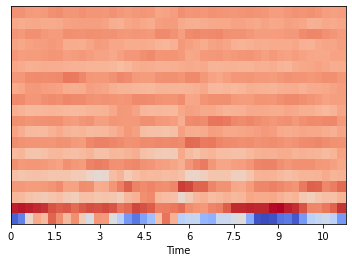

In [2]:
SAMPLING_FRQ = 2000
BINS = 20

# Process the first cat file
x, fs = librosa.load(base_path + pet_sounds['cat'][0], sr=SAMPLING_FRQ)
mfccs = librosa.feature.mfcc(x, sr=fs, n_mfcc=BINS)
librosa.display.specshow(mfccs, sr=fs, x_axis='time')

# 2.) Process each into X and Y matrices. Apply a classifier and comment on results.

### Some setup

In [3]:
# Up sampling frequency to 4k
SAMPLING_FRQ = 4000

# Set the FFT length
# https://librosa.org/doc/main/ioformats.html?highlight=n_fft
# https://librosa.org/doc/main/glossary.html?highlight=n_fft
FFT = (2048 * SAMPLING_FRQ) // 22050

# Generator function to get all dogs/cats files and label
def get_pet(ps_dict=pet_sounds):
    for pet in ['cat', 'dog']:
        for i in range(0, len(ps_dict[pet])):
            yield(ps_dict[pet][i], pet)
        
    return None

### Convert each file into a waveform and store to DataFrame

In [4]:
%%time
# Setup dict for conversion to dataframe
mfcc_dict = {}

for i in range(0, BINS):
    mfcc_dict[f'MFCC_{i}'] = []
    
mfcc_dict['class'] = []
mfcc_dict['file'] = []

# Begin processing
for file, pet in get_pet():
    # Load waveform and then MFCCs
    wf, sr = librosa.load(base_path + file, sr=SAMPLING_FRQ)
    assert(sr == SAMPLING_FRQ)
    mfccs = librosa.feature.mfcc(wf, sr=sr, n_mfcc=BINS,  n_fft=FFT)
    
    # Add the mfccs values to the dict
    for i in range(len(mfccs)):
        mfcc_dict[f'MFCC_{i}'] += list(mfccs[i])
        
    # Add the class and file data to the dict
    mfcc_dict['class'] += [pet] * len(mfccs[0])
    mfcc_dict['file'] += [file] * len(mfccs[0])
    
# Create df
ps_df = pd.DataFrame(mfcc_dict)  
display(ps_df.head())

,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,MFCC_12,MFCC_13,MFCC_14,MFCC_15,MFCC_16,MFCC_17,MFCC_18,MFCC_19,class,file
0,-401.809357,-6.883381,37.074257,8.628761,-29.159145,8.689098,-18.552784,9.624913,7.769758,-2.060371,...,-4.356100,21.479511,-0.473684,9.695919,-4.573258,6.906791,-5.868635,6.419684,cat,cat_1.wav
1,-451.546722,71.212662,9.399033,1.004310,-21.921335,-6.178901,-17.028158,-3.420984,-9.570553,5.378980,...,1.343739,15.090795,-5.538236,0.010958,-16.734739,-3.696347,-1.431490,0.020051,cat,cat_1.wav
2,-467.586639,66.741180,-3.497698,-1.904688,-12.276025,-3.175431,-26.669403,9.023046,-14.347551,1.665918,...,-5.439007,12.779630,-7.836804,-1.615031,-14.847106,-4.164679,-6.856385,5.027202,cat,cat_1.wav
3,-462.881042,73.702545,1.519370,0.349248,-28.249584,-11.111385,-18.216236,-1.470417,-10.215892,3.547068,...,-2.649648,16.240955,0.552022,-1.608632,-11.360909,-7.012007,-4.216261,7.969719,cat,cat_1.wav
4,-432.400360,83.312820,11.399535,10.474150,-14.801990,2.420839,-21.404341,8.065122,-16.961800,6.195270,...,-7.925519,8.626961,-0.748905,1.306564,-19.525753,-9.941595,-4.196818,6.096716,cat,cat_1.wav


CPU times: user 1min 31s, sys: 325 ms, total: 1min 31s
Wall time: 23 s


In [5]:
# Split the data into X and Y
X_filter = [col for col in ps_df.columns if col not in ['file', 'class']]
X = ps_df.loc[:, X_filter].values

Y_binarize = lambda x: 0 if x == 'cat' else 1
Y = ps_df.loc[:, 'class']
Y = Y.apply(Y_binarize)
Y = Y.values.ravel()

### Do some sklearn

In [8]:
%%time

# parameters found through a GridSearchCV but it took 2 hours and I was mad it was SVC so deleted it
model = SVC(C=10, kernel='poly') 
kfold = KFold(n_splits=10, shuffle=True)

scores = cross_val_score(model, X, Y, cv=kfold)

score_str = ''
for idx, score in enumerate(scores):
    score_str += f'{score:.3f}'
    
    if idx < len(scores):
        score_str += ', '

print(f'Model: {model}')
print(f'\tScores: {score_str}')
print(f'\tMean: {np.mean(scores):.4f}')
print(f'\tSTD: {np.std(scores):.4f}')
print('\n') # separates from the times from %%time

Model: SVC(C=10, kernel='poly')
	Scores: 0.883, 0.868, 0.863, 0.865, 0.884, 0.872, 0.876, 0.875, 0.877, 0.869, 
	Mean: 0.8733
	STD: 0.0068


CPU times: user 34.8 s, sys: 833 ms, total: 35.6 s
Wall time: 35.7 s
